In [ ]:
# Useful function for general activation function (at the moment tanh and centered sigmoid + linear to compare with explicit formulas)

import numpy as np
from scipy.integrate import quad

# Define the activation function for the neural network
def activation_function(x, act_fun = "Tanh"):
    if act_fun == "Tanh":
        return np.tanh(x) # Hyperbolic tangent function
    elif act_fun == "Sigmoid":
        # The usual expression is 1 / (1 + np.exp(-x)), we use the expression using the hyperbolic tangent
        return (1 / 2) + np.tanh(x / 2) / 2 # Sigmoid function
    elif act_fun == "Linear":
        return x / np.sqrt(2) # Linear activation function

# Derivative of the activation function
def activation_derivative(x, act_fun = "Tanh"):
    if act_fun == "Tanh":
        return 1 / np.cosh(x)**2  # derivative of tanh function
    elif act_fun == "Sigmoid":
        # The usual expression is np.exp(-x) / (1 + np.exp(-x))**2, we use the expression using the hyperbolic tangent
        return 1 / (4 * np.cosh(x / 2)**2) # derivative of Sigmoid function
    elif act_fun == "Linear":
        return 1 / np.sqrt(2) # derivative of Linear activation function

# Hessian of the activation function
def activation_hessian(x, act_fun = "Tanh"):
    if act_fun == "Tanh":
        return -2 * np.tanh(x) / np.cosh(x)**2  # second derivative of tanh function
    elif act_fun == "Sigmoid":
        # The usual expression is -np.exp(x) * (np.exp(x) - 1) / (1 + np.exp(x))**3, we use the expression using the hyperbolic tangent
        return -np.tanh(x / 2) / (4 * np.cosh(x / 2)**2) # second derivative of Sigmoid function
    elif act_fun == "Linear":
        return 0 # second derivative of Linear activation function

# Define the MGF integrand function
def integrand(x, lam = 1, k = 1, act_fun = "Tanh"):
    return np.exp(lam * (activation_function(x * np.sqrt(k), act_fun))**2 - x**2 / 2)/ np.sqrt(2 * np.pi)

# Define the integrand for the derivative of the MGF with respect to lambda
def integrand_derivative(x, lam = 1, k = 1, act_fun = "Tanh"):
    return activation_function(x * np.sqrt(k), act_fun)**2 * np.exp(lam * (activation_function(x * np.sqrt(k), act_fun))**2 - x**2 / 2) / np.sqrt(2 * np.pi)

# Define the integrand for the hessian of the MGF
def integrand_hessian(x, mean = 0, lam = 1, k = 1, act_fun = "Tanh"):
    return (activation_function(x * np.sqrt(k), act_fun)**2 - mean)**2 * np.exp(lam * (activation_function(x * np.sqrt(k), act_fun))**2 - x**2 / 2) / np.sqrt(2 * np.pi)

# Define the integrand for the derivative of the MGF with respect to k
def integrand_derivative_k(x, lam = 1, k = 1, act_fun = "Tanh"):
    return activation_derivative(x * np.sqrt(k), act_fun) * activation_function(x * np.sqrt(k), act_fun) * x * np.exp(lam * (activation_function(x * np.sqrt(k), act_fun))**2 - x**2 / 2) / np.sqrt(2 * np.pi)

# Test the functions
activation = "Sigmoid"
def inte(x, lam = 1, k = 1, act_fun = activation):
    return integrand_derivative(x, lam, k, act_fun)
result, error = quad(inte, -np.inf, np.inf, args=(-3, 1))
print(f"Value over R: {result}. Estimated error: {error}")

Value over R: 0.09228376314679088. Estimated error: 1.6666443097460158e-10


Total runtime for quadrature is 0.03405618667602539



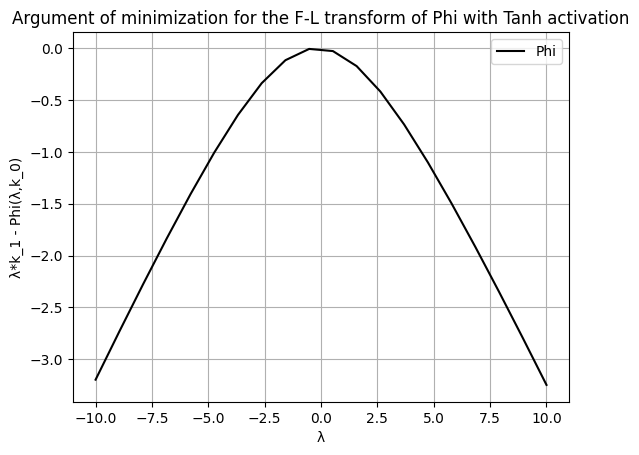

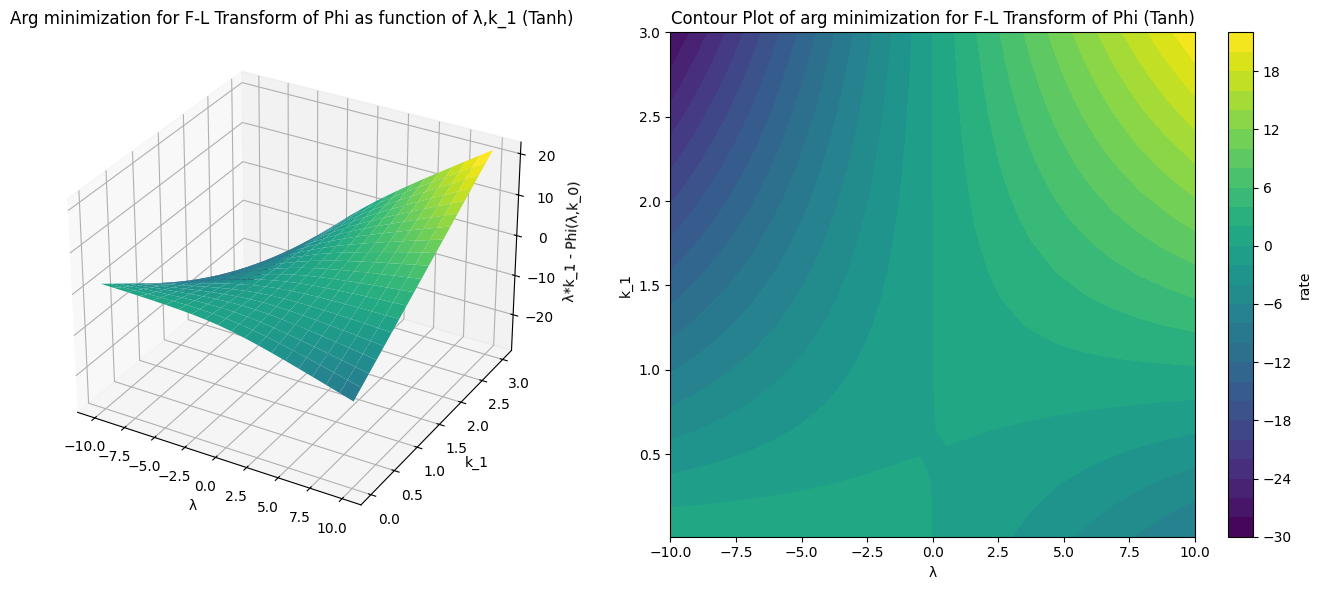

In [ ]:
import numpy as np

# Define the LMGT (Phi)
def Phi(lam, k, act_fun = "Linear", direct = True):
    if act_fun == "Linear" and direct:
        return -np.log(1 - lam * k) / 2
    elif act_fun == "ReLU":
        return np.log((1 + (1 - 2 * lam * k)**(- 1 / 2)) / 2)
    else:
        def inte(x, lam = 1, k = 1, act_fun = act_fun):
            return integrand(x, lam, k, act_fun)
        return np.log(quad(inte, -np.inf, np.inf, args = (lam, k))[0])

# Define the gradient of Phi with respect to lambda
def gradient_Phi_lam(lam, k, act_fun = "Linear", direct = True):
    if act_fun == "Linear" and direct:
        return k / (2 * (1 - lam * k))
    elif act_fun == "ReLU":
        return k / ((1 - 2 * lam * k) * (1 + np.sqrt(1 - 2 * lam * k)))
    else:
        def inte(x, lam = 1, k = 1, act_fun = act_fun):
            return integrand(x, lam, k, act_fun)
        def inte_der(x, lam = 1, k = 1, act_fun = act_fun):
            return integrand_derivative(x, lam, k, act_fun)
        numerator = quad(inte_der, -np.inf, np.inf, args = (lam, k))[0]
        denominator = quad(inte, -np.inf, np.inf, args = (lam, k))[0]
        return numerator / denominator

# Define the gradient of Phi with respect to k
def gradient_Phi_k(lam, k, act_fun = "Linear", direct = True):
    if act_fun == "Linear" and direct:
        return lam / (2 * (1 - lam * k))
    elif act_fun == "ReLU":
        return lam / ((1 - 2 * lam * k) * (1 + np.sqrt(1 - 2 * lam * k)))
    else:
        def inte(x, lam = 1, k = 1, act_fun = act_fun):
            return integrand(x, lam, k, act_fun)
        def inte_der_k(x, lam = 1, k = 1, act_fun = act_fun):
            return integrand_derivative_k(x, lam, k, act_fun)
        numerator = quad(inte_der_k, -np.inf, np.inf, args = (lam, k))[0]
        denominator = quad(inte, -np.inf, np.inf, args = (lam, k))[0]
        return lam * numerator / (denominator * np.sqrt(k))

# Define the hessian of Phi with respect to lambda
def hessian_Phi_lam(lam, k, act_fun = "Linear", direct = True):
    if act_fun == "Linear" and direct:
        return k**2 / (2 * (1 - lam * k)**2)
    elif act_fun == "ReLU":
        return (-6 * lam * k**3 + 2 * k**2 * np.sqrt(1 - 2 * lam * k) + 3 * k**2) / ((1 - 2 * lam * k)**(5 / 2) * (1 + np.sqrt(1 - 2 * lam * k))**2)
    else:
        def inte(x, lam = 1, k = 1, act_fun = act_fun):
            return integrand(x, lam, k, act_fun)
        def inte_der(x, lam = 1, k = 1, act_fun = act_fun):
            return integrand_derivative(x, lam, k, act_fun)
        def inte_hes(x, lam = 1, k = 1, act_fun = act_fun):
            return integrand_hessian(x, lam, k, act_fun)
        mean = quad(inte_der, -5, 5 , args = (lam, k))[0]
        numerator = quad(inte_hes, -5, 5, args = (mean, lam, k))[0] 
        denominator = quad(inte, -5, 5, args = (lam, k))[0]
        return numerator / denominator

# Define the hessian of Phi with respect to k
def hessian_Phi_k(lam, k, act_fun = "Linear", direct = True):
    if act_fun == "Linear" and direct:
        return lam**2 / (2 * (1 - lam * k)**2)
    elif act_fun == "ReLU":
        return (-6 * lam**3 * k + 2 * lam**2 * np.sqrt(1 - 2 * lam * k) + 3 * lam**2) / ((1 - 2 * lam * k)**(5 / 2) * (1 + np.sqrt(1 - 2 * lam * k))**2)
    else:
        return print("Not available at the moment")

# Define the mixed hessian of Phi
def mixed_hessian_Phi(lam, k, act_fun = "Linear", direct = True):
    if act_fun == "Linear" and direct:
        return 1 / (2 * (1 - lam * k)**2)
    elif act_fun == "ReLU":
        return (1 + np.sqrt(1 - 2 * lam * k) - (lam * k) - 2 * (lam * k)**2) / ((1 - 2 * lam * k)**(5 / 2) * (1 + np.sqrt(1 - 2 * lam * k))**2)
    else:
        return print("Not available at the moment")

# Test the functions
import time as tm
activation = "Tanh"
k_0 = 2
k_1 = 0.5
# Range of lambda values
lambda_values = np.linspace(-10, 10, 20) # Tanh, Sigmoid #np.linspace(-5, 1 / (1.01 * k_0), 20) Linear #np.linspace(-5, 1 / (2.01 * k_0), 20) ReLU
    # Analytic solution for Linear and ReLU, otherwise approximation by quadrature
start = tm.time()
results_th = [k_1 * lam - Phi(lam, k_0, activation)  for lam in lambda_values]
end = tm.time()
print(f"Total runtime for quadrature is {end - start}\n")
    # Compute the argument of maximization for the F-L transform of Phi using quadrature (for Linear activation)
#start = tm.time()
#results_q_lin = [k_1 * lam - Phi(lam, k_0, activation, False)  for lam in lambda_values]
#end = tm.time()
#print(f"Total runtime for quadrature is {end - start}\n")
# Plotting
import matplotlib.pyplot as plt
plt.plot(lambda_values, results_th, label = 'Exact', linestyle = '-', color = 'orange')
#plt.plot(lambda_values, results_q_lin, label = 'Quadrature', linestyle = ':', color = 'black')
plt.title(f'Argument of maximization for the F-L transform of Phi with {activation} activation')
plt.xlabel('λ')
plt.ylabel('λ*k - Phi(λ,K)')
plt.grid()
plt.legend()
plt.show()

# Grid points for 3D plot + contour plot
k_1_values = np.linspace(0.01, 3, 20)
LAM, K1 = np.meshgrid(lambda_values, k_1_values)
k_values = np.stack([LAM.ravel(), K1.ravel()], axis=1)
    # Analytic solution for Linear and ReLU, otherwise approximation by quadrature
results = [k[1] * k[0] - Phi(k[0], k_0, activation) for k in k_values]
results = np.array(results).reshape(LAM.shape)
# Plotting 3D
fig = plt.figure(figsize = (14, 6))
# Plot 3D
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax1.plot_surface(LAM, K1, results, cmap = 'viridis', edgecolor = 'none')
ax1.set_title(f"Arg maximization for F-L Transform of Phi as function of λ,k ({activation})")
ax1.set_xlabel('λ')
ax1.set_ylabel('k')
ax1.set_zlabel('λ*k - Phi(λ,K)')
# Contour plot
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(LAM, K1, results, levels = 30, cmap = 'viridis')
fig.colorbar(contour, ax = ax2, label = 'λ*k - Phi(λ,K)')
ax2.set_title(f"Contour Plot")
ax2.set_xlabel('λ')
ax2.set_ylabel('k')
plt.tight_layout()
plt.show()

In [ ]:
# Numerical methods to compute the Fenchel-Legendre transform of Phi

# Compute Fenchel-Legendre transform of LMGF for linear activation (A=1/2) using the analytic formula
def theoretical_Phi_conjugate_lin(k_1, k_0):
    return (k_1 / k_0) - (np.log(2 * k_1 / k_0) / 2) - (1 / 2), (k_1 - k_0 / 2) / (k_0 * k_1)

# Scipy optimization
from scipy.optimize import minimize # if we want to maximize we can use the relation max f = -min (-f)
def Phi_conjugate_Scipy(k_1, k_0, act_fun = "Linear", direct = True, starting_point = 0.1):
    def objective(lam):
            return (-lam * k_1 + Phi(lam, k_0, act_fun, direct),  -k_1 + gradient_Phi_lam(lam, k_0, act_fun, direct))
    if act_fun == "Linear":
        result = minimize(objective, starting_point, jac = True, method='L-BFGS-B', bounds = ((-np.inf, 1 / (1.0001 * k_0)),), options = {'disp': False})
    elif act_fun == "ReLU":
        result = minimize(objective, starting_point, jac = True, method='L-BFGS-B', bounds = ((-np.inf, 1 / (2.0001 * k_0)),), options = {'disp': False})
    else:
        result = minimize(objective, starting_point, jac = True, method='BFGS', options={'disp': False})
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    lam = result.x[0]
    Phi_conj = -result.fun
    return Phi_conj, lam

# Gradient Ascent
def Phi_conjugate_GA(k_1, k_0, act_fun = "Linear", direct = True, learning_rate = 5, starting_point = 1, num_iterations = 30):
    if (act_fun == "Linear") and (starting_point >= 1 / k_0): # check the starting point is in the domain
        # max possible starting point
        lam = 1 / (1.1 * k_0)
    elif (act_fun == "ReLU") and (starting_point >= 1 / (2 * k_0)):
        # max possible starting point
        lam = 1 / (2.1 * k_0)
    else:
        lam = starting_point
    for _ in range(num_iterations):
        grad_Phi_lam = gradient_Phi_lam(lam, k_0, act_fun, direct)
        grad = k_1 - grad_Phi_lam
        lam_updated = lam + learning_rate * grad
        if act_fun == "Linear":
            if lam_updated >= 1 / k_0:
                # max possible step
                lam = 1 / (1.01 * k_0)
            else:
                lam = lam_updated
        elif act_fun == "ReLU":
            if lam_updated >= 1 / (2 * k_0):
                # max possible step
                lam = 1 / (2.1 * k_0) 
            else:
                lam = lam_updated
        else:
            lam = lam_updated
    Phi_conj = lam * k_1 - Phi(lam, k_0, act_fun, direct)
    return Phi_conj, lam

# Newton's method
def Phi_conjugate_Newton(k_1, k_0, act_fun = "Linear", direct = True, starting_point = 0.1, num_iterations = 10):
    if (act_fun == "Linear") and (starting_point >= 1 / k_0): # check the starting point is in the domain
        # max possible starting point
        lam = 1 / (1.01 * k_0)
    elif (act_fun == "ReLU") and (starting_point >= 1 / (2 * k_0)):
        # max possible starting point
        lam = 1 / (2.01 * k_0)
    else:
        lam = starting_point
    for _ in range(num_iterations):
        grad_Phi_lam = gradient_Phi_lam(lam, k_0, act_fun, direct)
        hess_Phi_lam = hessian_Phi_lam(lam, k_0, act_fun, direct)
        grad = k_1 - grad_Phi_lam
        hess = -hess_Phi_lam
        lam_updated = lam - grad / hess
        if act_fun == "Linear":
            if lam_updated >= 1 / k_0:
                # max possible step
                lam = 1 / (1.01 * k_0)
            else:
                lam = lam_updated
        elif act_fun == "ReLU":
            if lam_updated >= 1 / (2 * k_0):
                # max possible step
                lam = 1 / (2.01 * k_0) 
            else:
                lam = lam_updated
        else:
            lam = lam_updated
    Phi_conj = lam * k_1 - Phi(lam, k_0, act_fun, direct)
    return Phi_conj, lam

# Testing the functions
import time as tm
k_1 = 0.9 # for Tanh activation this value must be in (0.1, 0.9)
k_0 = 0.5
activation = "Tanh"
learn_rate = 5 # for Tanh and Sigmoid this value can be large, for ReLU have to be small
start_point = 1
    # Analytic formula foe Linear activation
#Phi_conj_th_lin, lam_th_lin = theoretical_Phi_conjugate_lin(k_1, k_0)
#print(f"Analytic solution: Function value {Phi_conj_th_lin}, minimized at {lam_th_lin} (Linear activation)")
    # Scipy optimization (direct for Linear, using quadrature for Tanh and Sigmoid)
start = tm.time()
Phi_conj_scipy, lam_scipy = Phi_conjugate_Scipy(k_1, k_0, activation, True, start_point)
end = tm.time()
print(f"Scipy Optimization: Function value {Phi_conj_scipy}, minimized at: {lam_scipy}, total runtime {end - start} ({activation} activation)")
    # Gradient Ascent
start = tm.time()
Phi_conj_ga, lam_ga = Phi_conjugate_GA(k_1, k_0, activation, True, learn_rate, start_point)
end = tm.time()
print(f"Gradient Ascent: Function value: {Phi_conj_ga}, minimized at: {lam_ga}, total runtime {end - start} ({activation} activation)")
    # Newton's method
start = tm.time()
Phi_conj_newton, lam_newton = Phi_conjugate_Newton(k_1, k_0, activation, True, start_point)
end = tm.time()
print(f"Newton's Method: Function value {Phi_conj_newton}, minimized at: {lam_newton}, total runtime {end - start} ({activation} activation)")
    # Scipy optimization using quadrature (for Linear activation)
#start = tm.time()
#Phi_conj_scipy_q, lam_scipy_q = Phi_conjugate_Scipy(k_1, k_0, False, start_point)
#end = tm.time()
#print(f"Scipy Optimization using quadrature: Function value {Phi_conj_scipy_q}, minimized at: {lam_scipy_q}, total runtime {end - start} (Linear activation)")

Gradient Descent: Minimized value at: 15.48698152841329, Function value at minimized point: 3.2586935960664967
Newton's Method: Minimized value at: 7.046056115537069, Function value at minimized point: 2.602103042312761
Scipy Optimization: Minimized value at: 20.75338244214486, Function value at minimized point: 3.326759888041094


Total runtime of GD is 0.0009982585906982422

Total runtime of Newton is 0.0009982585906982422

Total runtime of Scipy is 0.03184938430786133

Total runtime of Scipy (using quadrature) is 3.044602394104004



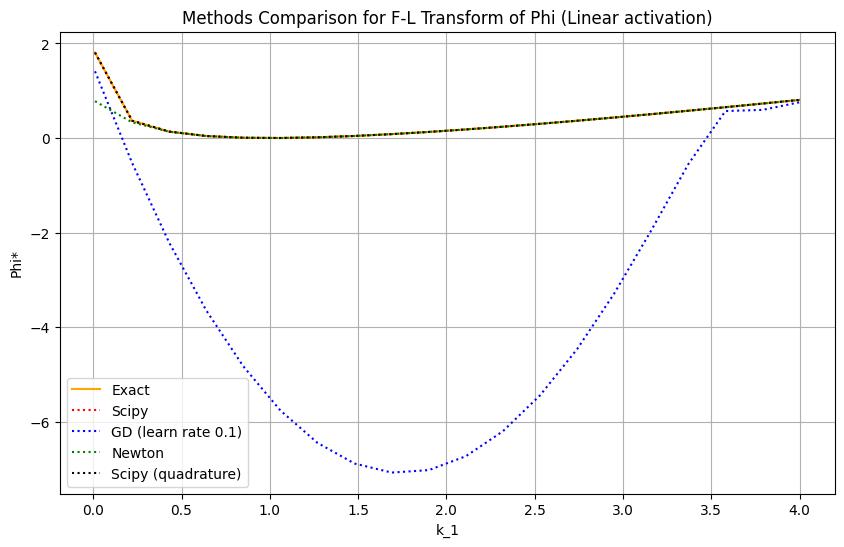

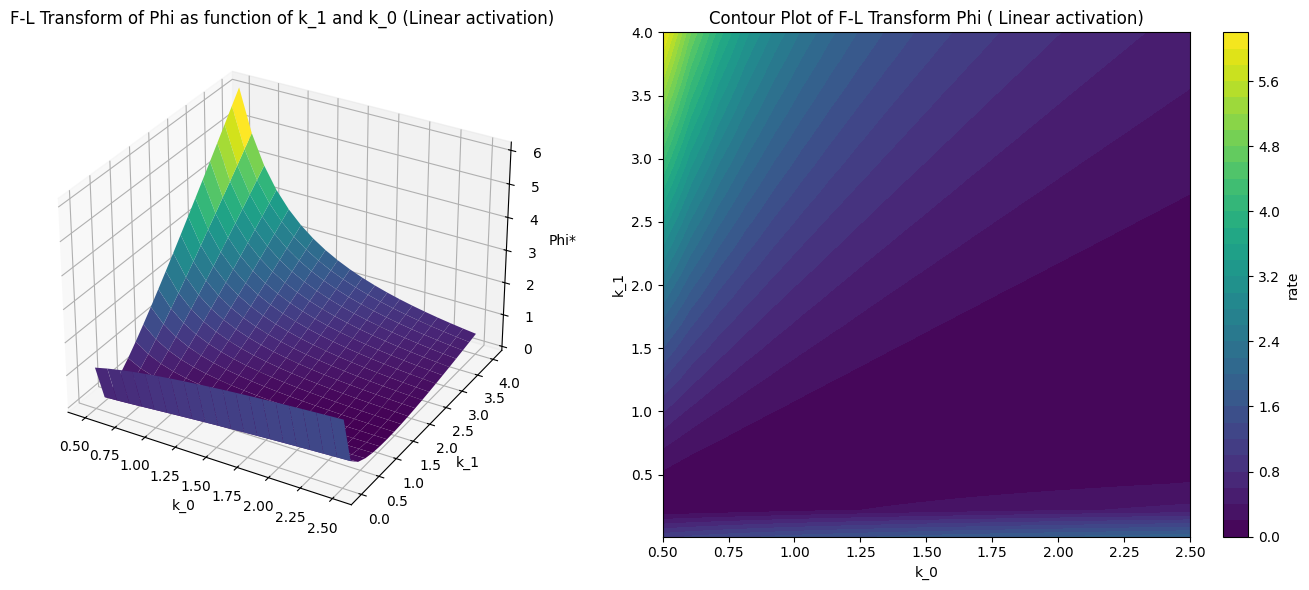

In [ ]:
# Plot Fenchel-Legendre transform of Phi computed with different methods

# Range of k_1 values
k_1_values = np.linspace(0.01, 4, 100) # for Tanh and Sigmoid activation these values must be in (0.1, 0.9) to use Scipy
# Range of k_0 values
k_0_values = np.linspace(0.5, 2.5, 100)
activation = "Linear"
learn_rate = 0.1 # for Tanh and Sigmoid this value have be large, for ReLU have to be small
start_point = 1

    # Analytic solution (for linear)
Phi_conj_th_lin = [theoretical_Phi_conjugate_lin(k, 2)[0] for k in k_1_values]
    # Scipy optimization
Phi_conj_scipy = [Phi_conjugate_Scipy(k, 2, activation, True, start_point)[0] for k in k_1_values]
    # Gradient Ascent
Phi_conj_gd = [Phi_conjugate_GA(k, 2, activation, True, start_point, learn_rate)[0] for k in k_1_values]
    # Newton's method   
Phi_conj_newton = [Phi_conjugate_Newton(k, 2, activation, True, start_point)[0] for k in k_1_values]
    # Scipy optimization using quadrature (for linear)
Phi_conj_scipy_q = [Phi_conjugate_Scipy(k, 2, activation, False, start_point)[0] for k in k_1_values]

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
plt.plot(k_1_values, Phi_conj_th_lin, label = 'Exact', linestyle = '-', color = 'orange')
plt.plot(k_1_values, Phi_conj_scipy, label = 'Scipy', linestyle = ':', color = 'red')
plt.plot(k_1_values, Phi_conj_gd, label = f'GA (learn rate {learn_rate})', linestyle = ':', color = 'blue')
plt.plot(k_1_values, Phi_conj_newton, label = 'Newton', linestyle = ':',  color = 'green')
plt.plot(k_1_values, Phi_conj_scipy_q, label = 'Scipy (quadrature)', linestyle = ':', color = 'black')
plt.title(f'F-L Transform of Phi ({activation} activation)')
plt.xlabel('k')
plt.ylabel('Phi*')
plt.legend()
plt.grid()
plt.show()

# Grid points for 3D plot + contour plot
K0, K1 = np.meshgrid(k_0_values, k_1_values)
k_values = np.stack([K0.ravel(), K1.ravel()], axis=1)
# Scipy optimization
results = [Phi_conjugate_Scipy(k[1], k[0], activation, True, start_point)[0] for k in k_values]
results = np.array(results).reshape(K0.shape)
# Plotting
fig = plt.figure(figsize = (14, 6))
# Plot 3D
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax1.plot_surface(K0, K1, results, cmap = 'viridis', edgecolor = 'none')
ax1.set_title(f"F-L Transform of Phi as function of k and K ({activation} activation)")
ax1.set_xlabel('K')
ax1.set_ylabel('k')
ax1.set_zlabel('Phi*')
# Contour plot
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(K0, K1, results, levels = 30, cmap = 'viridis')
fig.colorbar(contour, ax = ax2, label = 'Phi*')
ax2.set_title(f"Contour Plot")
ax2.set_xlabel('K')
ax2.set_ylabel('k')
plt.tight_layout()
plt.show()

In [ ]:
# We recursively compute the rate function I(k_output, k_input, layer) for a given layer
# recall that the recursive definition of the rate function is:
# I_K(k_output, k_input, layer) = min_{k_hidden_layer > 0} I(k_hidden_layer, k_input, layer - 1) + Phi_conjugate(k_output, k_hidden_layer)
# while for layer == 1, we have:
# I_K(k_output, k_input, 1) = Phi_conjugate(k_output, k_input)
# We actually define the function so that its output is a double (I_value, k_hidden_layer)
# where I_value is the value of the rate function and k_hidden_layer is the optimal value for the minmization problem

# Calculate the theoretical value of the rate function I for Linear activation
def theoretical_I_K_lin(k_output, k_input, layer):
    r = (2**layer * k_output / k_input)
    return (layer / 2) * (r**(1 / layer) - np.log(r**(1 / layer)) - 1), (k_input**(1 / layer)) * (k_output**((layer - 1) / layer))

# Scipy optimization
def I_K_Scipy(k_output, k_input, layer, act_fun = "Linear", direct = True, starting_point = 1):
    if layer == 1:
        # Base case: compute the legendre transform directly
        Phi_conj, _ = Phi_conjugate_Scipy(k_output, k_input, act_fun, direct, starting_point)
        return Phi_conj, k_input  # k_hidden_layer is just k_input in this case
    else:
        # define the target function for the current layer
        def target_function_and_gradient(k_hidden_layer):   
            # Compute the legendre transform for the current layer
            Phi_conj_current, lam_current = Phi_conjugate_Scipy(k_output, k_hidden_layer, act_fun, direct, starting_point)
            # Compute the value of the rate function for the past layer and obtain the past optimal k_hidden_layer
            I_prev, k_hidden_layer_prev = I_K_Scipy(k_hidden_layer, k_input, layer - 1, act_fun, direct, starting_point = k_hidden_layer)
            # Compute the legendre transform for the previous layer (this is needed to compute the gradient)
            _, lam_prev = Phi_conjugate_Scipy(k_hidden_layer, k_hidden_layer_prev, act_fun, direct, starting_point)
            # Define the value 
            value = I_prev + Phi_conj_current
            # Define the gradient of the target function 
            gradient = - gradient_Phi_k(lam_current, k_hidden_layer, act_fun, direct) + lam_prev
            return (value, gradient)
        # Use scipy's minimize to find the optimal k_hidden_layer
        if act_fun == "Tanh":
            result = minimize(target_function_and_gradient, x0 = k_output, method='L-BFGS-B', jac = True, bounds = ((0.0001, 0.9),), options = {'disp': False})
        else:
            result = minimize(target_function_and_gradient, x0 = k_output, method='L-BFGS-B', jac = True, bounds = ((0.0001, np.inf),), options = {'disp': False})
        if not result.success:
            raise ValueError("Optimization failed: " + result.message)
        return result.fun, result.x[0]

# Gradient Descent
def I_K_GD(k_output, k_input, layer, act_fun = "Linear", direct = True, learning_rate = 1, starting_point = 0.3, num_iterations = 30):
    if layer == 1:
        # Base case: compute the legendre transform directly
        Phi_conj, _ = Phi_conjugate_GA(k_output, k_input, act_fun)
        return Phi_conj, k_input  # k_hidden_layer is just k_input in this case
    else:
        k_hidden_layer = starting_point
        for _ in range(num_iterations):
            _, lam_current = Phi_conjugate_GA(k_output, k_hidden_layer, act_fun)
            _, k_hidden_layer_prev = I_K_GD(k_hidden_layer, k_input, layer - 1, act_fun, direct, learning_rate, starting_point, num_iterations)
            _, lam_prev = Phi_conjugate_GA(k_hidden_layer, k_hidden_layer_prev, act_fun)
            grad = - gradient_Phi_k(lam_current, k_hidden_layer, act_fun, direct) + lam_prev
            k_updated = k_hidden_layer - learning_rate * grad
            if act_fun == "Tanh":
                if k_updated > 0.9:
                    # max possible step
                    k_hidden_layer = 0.9
                elif k_updated <= 0:
                    # min possible step
                    k_hidden_layer = 0.001
                else:
                    k_hidden_layer = k_updated
            else:
                if k_updated <= 0:
                    # min possible step
                    k_hidden_layer = 0.001
                else:
                    k_hidden_layer = k_updated
    I_k = Phi_conjugate_GA(k_output, k_hidden_layer, act_fun)[0] + I_K_GD(k_hidden_layer, k_input, layer - 1, act_fun, direct, learning_rate, starting_point, num_iterations)[0]
    return I_k, k_hidden_layer

# Newton's method (no available for Tanh and Sigmoid)
def I_K_Newton(k_output, k_input, layer, act_fun = "Linear", direct = True, starting_point = 1.3, num_iterations = 10):
    if layer == 1:
        # Base case: compute the legendre transform directly
        Phi_conj, _ = Phi_conjugate_Newton(k_output, k_input, act_fun, direct)
        return Phi_conj, k_input  # k_hidden_layer is just k_input in this case
    else:
        k_hidden_layer = starting_point
        for _ in range(num_iterations):
            _, lam_current = Phi_conjugate_Newton(k_output, k_hidden_layer, act_fun, direct)
            _, k_hidden_layer_prev = I_K_Newton(k_hidden_layer, k_input, layer - 1, act_fun, direct, starting_point, num_iterations)
            _, lam_prev = Phi_conjugate_Newton(k_hidden_layer, k_hidden_layer_prev, act_fun, direct)
            grad = - gradient_Phi_k(lam_current, k_hidden_layer, act_fun, direct) + lam_prev
            hess_lam = hessian_Phi_lam(lam_current, k_hidden_layer, act_fun, direct)
            mix_hess = mixed_hessian_Phi(lam_current, k_hidden_layer, act_fun, direct)
            hess_k = hessian_Phi_k(lam_current, k_hidden_layer, act_fun, direct)
            hess_lam_prev = hessian_Phi_lam(lam_prev, k_hidden_layer_prev, act_fun, direct)
            hess = mix_hess**2 / hess_lam - hess_k + 1 / hess_lam_prev
            k_updated = k_hidden_layer - grad / hess
            if act_fun == "Tanh":
                if k_updated > 0.9:
                    # max possible step
                    k_hidden_layer = 0.9
                elif k_updated <= 0:
                    # min possible step
                    k_hidden_layer = 0.0001
                else:
                    k_hidden_layer = k_updated
            else:
                if k_updated <= 0:
                    # min possible step
                    k_hidden_layer = 0.0001
                else:
                    k_hidden_layer = k_updated
    I_k = Phi_conjugate_Newton(k_output, k_hidden_layer, act_fun, direct)[0] + I_K_Newton(k_hidden_layer, k_input, layer - 1, act_fun, direct, starting_point, num_iterations)[0]
    return I_k, k_hidden_layer

# Test the functions
import time as tm
k_output = 0.5  # for Tanh this value must be in (0.1, 0.7) to use Scipy
k_input = 2
layer = 2
activation = "Tanh"
learn_rate = 0.01 # small
start_point = 0.5 # for Linear have to be large, for ReLU have to be small
    # Analytic solution for Linear activation
#I_K_th_lin, k_opt_th_lin = theoretical_I_K_lin(k_output, k_input, layer)
#print(f"Analytic value of I_K for Linear Activation at layer {layer + 1}: {I_K_th_lin}, minimized at {k_opt_th_lin}")
    # Scipy optimization (direct for Linear, using quadrature for Tanh and Sigmoid)
start = tm.time()
I_K_scipy, k_opt_scipy = I_K_Scipy(k_output, k_input, layer, activation, True, start_point)
end = tm.time()
print(f"Rate Function I_K for {activation} Activation at Layer {layer + 1}: {I_K_scipy}, minimized at {k_opt_scipy}, total runtime {end - start} (Scipy)")
    # Gradient Descent
start = tm.time()
I_K_gd, k_opt_gd = I_K_GD(k_output, k_input, layer, activation, True, learn_rate, start_point)
end = tm.time()
print(f"Rate Function I_K for {activation} Activation at Layer {layer + 1}: {I_K_gd}, minimized at {k_opt_gd}, total runtime {end - start} (GD)")
    # Newton's method (no available for Tanh and Sigmoid)
#start = tm.time()
#I_K_newton, k_opt_newton = I_K_Newton(k_output, k_input, layer, activation, True, start_point)
#end = tm.time()
#print(f"Rate Function I_K for {activation} Activation at Layer {layer + 1}: {I_K_newton}, minimized at {k_opt_newton}, total runtime {end - start} (Newton)")
    # Scipy optimization using quadrarure (for Linear)
#start = tm.time()
#I_K_scipy_q, k_opt_scipy_q = I_K_Scipy(k_output, k_input, layer, activation, False, start_point)
#end = tm.time()
#print(f"Rate Function I_K for Linear Activation at Layer {layer + 1}: {I_K_scipy}, minimized at {k_opt_scipy}, total runtime {end - start} (Scipy using quadrature)")

In [ ]:
# Plot I_K computed with different methods
import numpy as np

# Range of k values
k_values = np.linspace(0.01, 0.7, 50) #for Tanh these values must be in (0.1, 0.7) to use Scipy
k_input = 2
layer = 2
activation = "Tanh"
learn_rate = 0.01 # for small
start_point = 0.5 # for Linear have to be large, for ReLU have to be small

    # Analytic solution (for Linear activation)
#results_th_lin = [theoretical_I_K_lin(k_output, k_input, layer)[0] for k_output in k_values]
    # Scipy optimization (direct for Linear, using quadrature for Tanh and Sigmoid)
results_scipy = [I_K_Scipy(k_output, k_input, layer, activation, True)[0] for k_output in k_values]
    # Gradient descent
results_gd = [I_K_GD(k_output, k_input, layer, activation, True, start_point, learn_rate)[0] for k_output in k_values]
    # Newton's method (no available for Tanh and Sigmoid)   
#results_newton = [I_K_Newton(k_output, k_input, layer, activation, True, start_point)[0] for k_output in k_values]
    # Scipy optimization using quadrature (for Linear activation)
#results_scipy_q = [I_K_Scipy(k_output, k_input, layer, activation, False)[0] for k_output in k_values]

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
#plt.plot(k_values, results_th_lin, label = 'Exact', linestyle = '-', color = 'orange')
plt.plot(k_values, results_scipy, label = 'Scipy', linestyle = '-', color = 'red')
plt.plot(k_values, results_gd, label = f'GD (learn rate {learn_rate})', linestyle = ':', color = 'blue')
#plt.plot(k_values, results_newton, label = f'Newton (start {start_point})', linestyle = ':',  color = 'orange')#'green')
#plt.plot(k_values, results_scipy_q, label = 'Scipy (quadrature)', linestyle = ':', color = 'black')
plt.title(f"I_K^{layer+1} for {activation} Activation at k^1={k_input}")#, start point {start_point}")
plt.xlabel(f'k^{layer+1}')
plt.ylabel(f'I_K^{layer+1}')
plt.grid()
plt.legend()
plt.show()

In [ ]:
from numpy import linalg as la
# Finally we want to calculate the rate funtion I_F for the output of the neural network

# Analytic rate function for Linear activation in shallow case (layer = 1).
# In deep case, use the analytic I_K for the Scipy optimization, in particular we need the gradient of I_K
def gradient_theoretical_I_K_lin(k_output, k_input, layer):
    return 1 / ((k_input**(1 / layer)) * (k_output**((layer - 1) / layer))) - (1 / (2 * k_output))
def theoretical_I_F_lin(x, k_input, layer):
    if layer == 1:
        # Shallow case: explicit formula
        value = (1 + np.sqrt(1 + 8 * la.norm(x)**2 / k_input)) / 4 - (1 / 2) - np.log((1 + np.sqrt(1 + 8 * la.norm(x)**2 / k_input)) / 2) / 2 + 2 * la.norm(x)**2 / (k_input * (1 + np.sqrt(1 + 8 * la.norm(x)**2 / k_input)))
        min_point = (1 + np.sqrt(1 + 8 * la.norm(x)**2 / k_input)) / k_input
        return value, min_point
    else:
        # Deep case: optimization using the analytic formula of I_K
        def target_function_and_gradient_output(k_last_layer):
            value = theoretical_I_K_lin(k_last_layer, k_input, layer)[0] + la.norm(x)**2 / (2 * k_last_layer)
            gradient = gradient_theoretical_I_K_lin(k_last_layer, k_input, layer) - la.norm(x)**2 / (2 * k_last_layer**2)
            return (value, gradient)
        # Use scipy's minimize to find the optimal k_hidden_layer
        result = minimize(target_function_and_gradient_output, x0 = k_input, jac = True, method = 'L-BFGS-B', bounds = ((0.0001, np.inf),), options = {'disp': False})
        # value of the minimization problem
        return result.fun, result.x[0]
        
# Scipy optimization
def I_F_Scipy(x, k_input, layer, act_fun = "Linear", direct = True, starting_point = 1):
    def target_function_and_gradient_output(k_last_layer):
        # Compute I_K for the last layer and the optimal k (related at the previous layer)
        I_K_value, k_hidden_layer = I_K_Scipy(k_last_layer, k_input, layer, act_fun, direct, starting_point)
        # The derivative of I_K is the previous optimal lambda for Phi_conjugate
        _, lam = Phi_conjugate_Scipy(k_last_layer, k_hidden_layer, act_fun, direct, starting_point)
        # Define the value and the derivative
        value = I_K_value + la.norm(x)**2 / (2 * k_last_layer)
        gradient = lam - la.norm(x)**2 / (2 * k_last_layer**2)
        return (value, gradient)
    # Use scipy's minimize to find the optimal k_hidden_layer
    if act_fun == "Tanh":
        result = minimize(target_function_and_gradient_output, x0 = k_input, jac = True, method = 'L-BFGS-B', bounds = ((0.0001, 0.7),), options = {'disp': False})
    else:
        result = minimize(target_function_and_gradient_output, x0 = k_input, jac = True, method = 'L-BFGS-B', bounds = ((0.0001, np.inf),), options = {'disp': False})
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    return result.fun, result.x[0]

# Gradient Descent (for Tanh and Sigmoid)
def I_F_GD(x, k_input, layer, learning_rate = 0.01, starting_point = 0.1, num_iterations = 30):
    k_last_layer = starting_point
    for _ in range(num_iterations):
        _, k_hidden_layer = I_K_GD(k_last_layer, k_input, layer)
        _, lam = Phi_conjugate_GA(k_last_layer, k_hidden_layer)
        grad = lam - la.norm(x)**2 / (2 * k_last_layer**2)
        k_updated = k_last_layer - learning_rate * grad
        if k_updated > 3:
            # max possible step
            k_last_layer = 3
        elif k_updated <= 0:
            # min possible step
            k_last_layer = 0.001
        else:
            k_last_layer = k_updated
    I_F = I_K_GD(k_last_layer, k_input, layer)[0] + la.norm(x)**2 / (2 * k_last_layer)
    return I_F, k_last_layer

# Newton's method (no available for Tanh and Sigmoid)
def I_F_Newton(x, k_input, layer, act_fun = "Linear", direct = True, starting_point = 1.8, num_iterations = 10):
    k_last_layer = starting_point
    for _ in range(num_iterations):
        _, k_hidden_layer = I_K_Newton(k_last_layer, k_input, layer, act_fun, direct, starting_point)
        _, lam = Phi_conjugate_Newton(k_last_layer, k_hidden_layer, act_fun, direct)
        grad = lam - la.norm(x)**2 / (2 * k_last_layer**2)
        hess = 1 / hessian_Phi_lam(lam, k_hidden_layer) + la.norm(x)**2 / k_last_layer**3
        k_updated = k_last_layer - grad / hess
        if act_fun == "Tanh":
            if k_updated > 0.9:
                # max possible step
                k_last_layer = 0.9
            elif k_updated <= 0:
                # min possible step
                k_last_layer = 0.0001
            else:
                k_last_layer = k_updated
        else:
            if k_updated <= 0:
                # min possible step
                k_last_layer = 0.0001
            else:
                k_last_layer = k_updated
    I_F = I_K_Newton(k_last_layer, k_input, layer, act_fun, direct, starting_point)[0] + la.norm(x)**2 / (2 * k_last_layer)
    return I_F, k_last_layer

# Test the functions
import time as tm
x = 10 #= np.arange(9) - 4
k_input = 2
layer = 2
activation = "ReLU"
#learn_rate = 0.001
start_point = 2.5
    # Analytic solution (for Linear activation)
#I_F_th_lin, k_opt_th_lin = theoretical_I_F_lin(x, k_input, layer)
#print(f"Analytic rate Function I_F for Linear activation at Layer {layer + 1}: {I_F_th_lin}, minimized at {k_opt_th_lin}")
    # Scipy optimization (direct for Linear, using quadrature for Tanh and Sigmoid)
start = tm.time()
I_F_scipy, k_opt_scipy = I_F_Scipy(x, k_input, layer, activation, True, start_point)
end = tm.time()
print(f"Rate Function I_F for {activation} activation at Layer {layer + 1}: {I_F_scipy}, minimized at {k_opt_scipy}, total runtime {end - start} (Scipy)")
    # Gradient Descent (for Tanh and Sigmoid)
#start = tm.time()
#I_F_gd, k_opt_gd = I_F_GD(x, k_input, layer, activation, True, learn_rate, start_point)
#end = tm.time()
#print(f"Rate Function I_F for {activation} activation at Layer {layer + 1}: {I_F_gd}, minimized at {k_opt_gd}, total runtime {end - start} (GD)")
    # Newton's method
start = tm.time()
I_F_newton, k_opt_newton = I_F_Newton(x, k_input, layer, activation, True, start_point)
end = tm.time()
print(f"Rate Function I_F for Linear activation at Layer {layer + 1}: {I_F_newton}, minimized at {k_opt_newton}, total runtime {end - start} (Newton)")
    # Scipy optimization using quadrature (for Linear activation)
#start = tm.time()
#I_F_scipy_q, k_opt_scipy_q = I_F_Scipy(x, k_input, layer, activation, False, start_point)
#end = tm.time()
#print(f"Rate Function I_F for Linear activation at Layer {layer + 1}: {I_F_scipy_q}, minimized at {k_opt_scipy_q}, total runtime {end - start} (Scipy using quadrature)")

C:\Users\User\AppData\Local\Temp\ipykernel_25048\3724592341.py:19: RuntimeWarning: invalid value encountered in sqrt
  return k / ((1 - 2 * lam * k) * (1 + np.sqrt(1 - 2 * lam * k)))
C:\Users\User\AppData\Local\Temp\ipykernel_25048\3724592341.py:49: RuntimeWarning: invalid value encountered in sqrt
  return (-6 * lam * k**3 + 2 * k**2 * np.sqrt(1 - 2 * lam * k) + 3 * k**2) / ((1 - 2 * lam * k)**(5 / 2) * (1 + np.sqrt(1 - 2 * lam * k))**2)
C:\Users\User\AppData\Local\Temp\ipykernel_25048\3724592341.py:49: RuntimeWarning: invalid value encountered in scalar power
  return (-6 * lam * k**3 + 2 * k**2 * np.sqrt(1 - 2 * lam * k) + 3 * k**2) / ((1 - 2 * lam * k)**(5 / 2) * (1 + np.sqrt(1 - 2 * lam * k))**2)


Rate Function I_F for ReLU activation at Layer 2: nan, minimized at nan (Newton)
Rate Function I_F for ReLU activation at Layer 2: 3.805455018151817, minimized at 30.947997526193628 (Scipy)


Total runtime of Newton is 8.128111362457275

Total runtime of Scipy is 260.233514547348



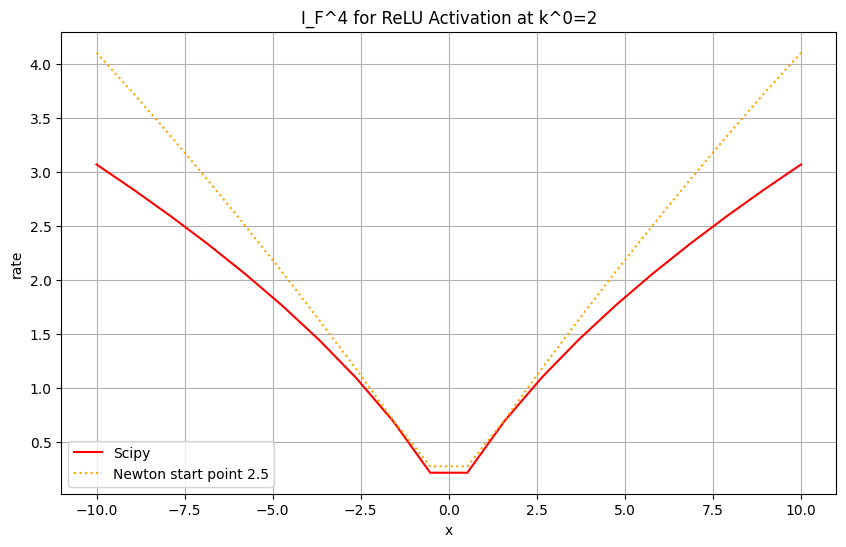

In [ ]:
# Plot I_F output dimension = 1
# Range of x values
x_values = np.linspace(-10, 10, 25)
k_input = 2
layer = 3
activation = "ReLU"
start_point = 2.5

    # Analytic solution (for Linear activation)
#results_th_lin = [theoretical_I_F_lin(x, k_input, layer)[0] for x in x_values]
    # Scipy optimization (direct for Linear, using quadrature for Tanh and Sigmoid)
results_scipy = [I_F_Scipy(x, k_input, layer, activation)[0] for x in x_values]
# Gradient Descent (for Tanh and Sigmoid)
#start = tm.time()
#results_gd = [I_F_GD(x, k_input, layer, learn_rate, start_point)[0] for x in x_values]
    # Newton's method (no available for Tanh and Sigmoid)
results_newton = [I_F_Newton(x, k_input, layer, activation, True, start_point)[0] for x in x_values]
    # Scipy optimization using quadrature (for Linear activation)
#results_scipy_q = [I_F_Scipy(x, k_input, layer, activation, False, start_point)[0] for x in x_values]

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
#plt.plot(x_values, results_th_lin, label = 'Exact', linestyle = '-',  color = 'orange')
plt.plot(x_values, results_scipy, label = 'Scipy', linestyle = '-', color = 'red')
#plt.plot(x_values, results_gd, label = f'GD (learn rate {learn_rate})', linestyle = ':',  color = 'blue')
plt.plot(x_values, results_newton, label = f'Newton start point {start_point}', linestyle = ':',  color = 'green')
#plt.plot(x_values, results_scipy_q, label = 'Scipy (quadrature)', linestyle = ':', color = 'black')
plt.title(f"I_F^{layer+1} for {activation} Activation at k^1={k_input}")
plt.xlabel('x')
plt.ylabel(f'I_F^{layer+1}')
plt.grid()
plt.legend()
plt.show()

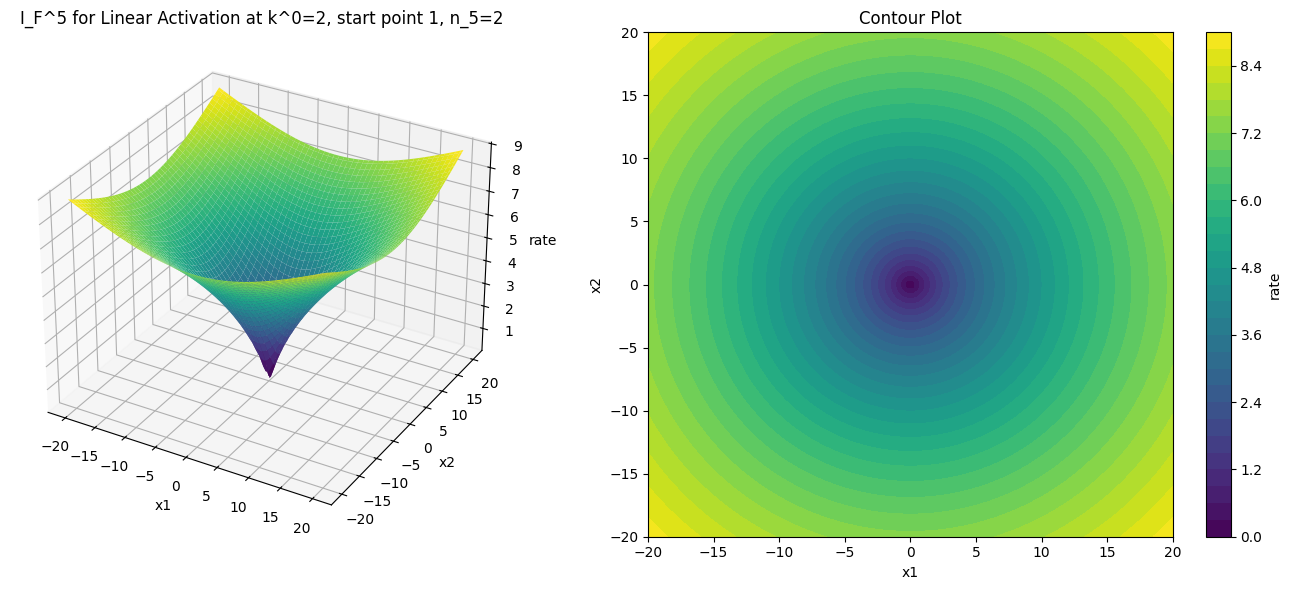

In [ ]:
# Plot I_F output dimension = 2
activation = "Linear"
layer = 1
k_input = 2

# Range of x values
x1_range = np.linspace(-20, 20, 101)
x2_range = np.linspace(-20, 20, 101)
# Grid points
X1, X2 = np.meshgrid(x1_range, x2_range)
x_values = np.stack([X1.ravel(), X2.ravel()], axis=1)

# Scipy optimization
results = [theoretical_I_F_lin(x, k_input, layer)[0] for x in x_values]#[I_F_Scipy(x, k_input, layer, activation, True)[0] for x in x_values]
results = np.array(results).reshape(X1.shape)

# Plotting
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (14, 6))
# Plot 3D
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax1.plot_surface(X1, X2, results, cmap = 'viridis', edgecolor = 'none')
ax1.set_title(f"I_F^{layer+1} for {activation} Activation at k^1={k_input}, start point 1, n_{layer+1}=2")
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel(f'I_F^{layer+1}')
# Contour plot
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(X1, X2, results, levels = 30, cmap = 'viridis')
fig.colorbar(contour, ax = ax2, label = f'I_F^{layer+1}')
ax2.set_title(f"Contour Plot")
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
plt.tight_layout()
plt.show()